In [1]:
#import libraries
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize #Used to extract words from documents
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer #Used to lemmatize words
from nltk import word_tokenize,pos_tag
from nltk.corpus import stopwords
import torch
import umap
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score
from sklearn.metrics.cluster import fowlkes_mallows_score
from gensim.parsing.preprocessing import remove_stopwords

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Amir\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Dataset Loading

In [3]:
categories = [
    'sci.med',
    'comp.graphics',
    'rec.sport.hockey',
]

In [4]:
temp_20newsgroup = fetch_20newsgroups(subset="all", remove=('headers', 'footers', 'quotes'),categories=categories)

In [5]:
temp_20newsgroup.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [6]:
len(temp_20newsgroup.data)

2962

In [7]:
df_inferSent = pd.DataFrame(data = {"data" : temp_20newsgroup.data, "target" : temp_20newsgroup.target})
df_inferSent

,data,target
0,\nIs there a precompiled version of hp2xx for ...,0
1,\nIs there any games being shown here in the U...,1
2,"\n\n\n\n Well, in my opinion the Canucks pl...",1
3,"\n\nCarl, it is not ""placebo effect"" if as hyp...",2
4,"only\nappreciated.\n\n\nPierre Turgeon, formel...",1
...,...,...
2957,: >over where it places its temp files: it jus...,0
2958,Just heard on the news that Mike Keenan former...,1
2959,\n\n\n\n\nDitto here too...\n\n,0
2960,I am 35 and am recovering from a case of Chick...,2


In [8]:
# LowerCasing

df_inferSent["data"] = df_inferSent["data"].str.lower()
df_inferSent

,data,target
0,\nis there a precompiled version of hp2xx for ...,0
1,\nis there any games being shown here in the u...,1
2,"\n\n\n\n well, in my opinion the canucks pl...",1
3,"\n\ncarl, it is not ""placebo effect"" if as hyp...",2
4,"only\nappreciated.\n\n\npierre turgeon, formel...",1
...,...,...
2957,: >over where it places its temp files: it jus...,0
2958,just heard on the news that mike keenan former...,1
2959,\n\n\n\n\nditto here too...\n\n,0
2960,i am 35 and am recovering from a case of chick...,2


In [9]:
# remove extra whitespace
def remove_whitespace(text):
    return  " ".join(text.split())

df_inferSent['data']=df_inferSent['data'].apply(remove_whitespace)
df_inferSent

,data,target
0,is there a precompiled version of hp2xx for do...,0
1,is there any games being shown here in the us ...,1
2,"well, in my opinion the canucks played a reall...",1
3,"carl, it is not ""placebo effect"" if as hypothe...",2
4,"only appreciated. pierre turgeon, formely of t...",1
...,...,...
2957,: >over where it places its temp files: it jus...,0
2958,just heard on the news that mike keenan former...,1
2959,ditto here too...,0
2960,i am 35 and am recovering from a case of chick...,2


In [10]:
#tokenize
df_inferSent['data']=df_inferSent['data'].apply(lambda X: word_tokenize(X))
df_inferSent.head()

,data,target
0,"[is, there, a, precompiled, version, of, hp2xx...",0
1,"[is, there, any, games, being, shown, here, in...",1
2,"[well, ,, in, my, opinion, the, canucks, playe...",1
3,"[carl, ,, it, is, not, ``, placebo, effect, ''...",2
4,"[only, appreciated, ., pierre, turgeon, ,, for...",1


In [11]:
# Stop word removal
en_stopwords = stopwords.words('english')

def remove_stopwords(text):
    result = []
    for token in text:
        if token not in en_stopwords:
            result.append(token)
            
    return result

df_inferSent['data'] = df_inferSent['data'].apply(remove_stopwords)
df_inferSent['data'].head()

0    [precompiled, version, hp2xx, dos, -, preferea...
1              [games, shown, us, wc, ?, ?, ?, thanks]
2    [well, ,, opinion, canucks, played, really, st...
3    [carl, ,, ``, placebo, effect, '', hypothesise...
4    [appreciated, ., pierre, turgeon, ,, formely, ...
Name: data, dtype: object

In [12]:
#Removing Punctuations
def remove_punct(text):
    
    tokenizer = RegexpTokenizer(r"\w+")
    lst=tokenizer.tokenize(' '.join(text))
    return lst

df_inferSent['data'] = df_inferSent['data'].apply(remove_punct)
df_inferSent.head()

,data,target
0,"[precompiled, version, hp2xx, dos, prefereably...",0
1,"[games, shown, us, wc, thanks]",1
2,"[well, opinion, canucks, played, really, stron...",1
3,"[carl, placebo, effect, hypothesised, sensory,...",2
4,"[appreciated, pierre, turgeon, formely, sabres...",1


In [13]:
#joinin tokenized words together

df_inferSent["data"] = df_inferSent["data"].str.join(" ")
df_inferSent

,data,target
0,precompiled version hp2xx dos prefereably 386 486,0
1,games shown us wc thanks,1
2,well opinion canucks played really strong game...,1
3,carl placebo effect hypothesised sensory respo...,2
4,appreciated pierre turgeon formely sabres isle...,1
...,...,...
2957,places temp files places current directory beg...,0
2958,heard news mike keenan formerly blackhawks fly...,1
2959,ditto,0
2960,35 recovering case chicken pox contracted 5 ye...,2


## Model Configuration

In [14]:
 # Load model for INfersent Model version 1 - Uses GLove and Model 2 uses Fasttext
from models import InferSent
model_version = 1 # Use model_version = 2 to use FastText
MODEL_PATH = "encoder/infersent%s.pkl" % model_version
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': model_version}
model = InferSent(params_model)
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [15]:
# Keep it on CPU or put it on GPU
use_cuda = False
model = model.cuda() if use_cuda else model

In [16]:
# Provide Location of the Glove Folder and FastText Folder
W2V_PATH = 'GloVe/glove.840B.300d.txt' if model_version == 1 else 'fastText/crawl-300d-2M.vec'
model.set_w2v_path(W2V_PATH)

In [17]:
# Load embeddings of K most frequent words
model.build_vocab_k_words(K=200000)

Vocab size : 200000


In [18]:
# Load some sentences
list_text = df_inferSent["data"].tolist()

In [19]:
list_text[5]

'm sure original respondent reiterate cones respond particular portions spectrum _rods_ respond certain parts visible spectrum bluegreen case reddish certain amphibia hoseshoe crab _limulus polyphemus_ photoreceptors respond certain portion spectrum etc common misconception confound wavelength specificity color sensitive however two synonymous sum beat dead horse 1 outputs cone matched number absorbed photons _irrespective_ absorbed photons wavelength cone outputs _indistinguishable_ 2 cones simply detectors different spectral sensitivities color sensitive rods ommatidia photoreceptors 3 color vision arises outputs receptors sample different parts spectrum cones case processed centrally handwave intentional ve worked published research rods cones 10 years adherence belief cones detect color frustrating n t take word m reposting excellent articles together two rather good oldish color vision texts texts robert boynton 1979 _human color vision_ holt rhiehart winston leo m hurvich 1981 _c

## Tokenization and Encoding the Sentences!

In [20]:
subset_list_text = list_text
targets = []
new_subset_list_text = []
embeddings_summed = []

from nltk.tokenize import sent_tokenize
for idx,each in enumerate(subset_list_text):
    if (len(each) != 0):
        each = each[:int(len(each)/2)] #reduce workload..
    for sent in sent_tokenize(each):
        new_subset_list_text.append(sent) 
    if len(new_subset_list_text) == 0 : new_subset_list_text.append('empty') 
    embeddings = model.encode(new_subset_list_text, bsize=128, tokenize=False, verbose=True)
    embeddings = [sum(x)/len(x) for x in zip(*embeddings)]
    embeddings_summed.append(embeddings)
    new_subset_list_text = []
    targets.append(idx)

Nb words kept : 4/5 (80.0%)
Speed : 0.7 sentences/s (cpu mode, bsize=128)
Nb words kept : 4/4 (100.0%)
Speed : 32.3 sentences/s (cpu mode, bsize=128)
Nb words kept : 31/32 (96.9%)
Speed : 4.0 sentences/s (cpu mode, bsize=128)
Nb words kept : 6/8 (75.0%)
Speed : 21.2 sentences/s (cpu mode, bsize=128)
Nb words kept : 4/6 (66.7%)
Speed : 39.4 sentences/s (cpu mode, bsize=128)
Nb words kept : 78/88 (88.6%)
Speed : 1.9 sentences/s (cpu mode, bsize=128)
Nb words kept : 43/45 (95.6%)
Speed : 3.2 sentences/s (cpu mode, bsize=128)
Nb words kept : 15/15 (100.0%)
Speed : 11.1 sentences/s (cpu mode, bsize=128)
Nb words kept : 26/28 (92.9%)
Speed : 5.4 sentences/s (cpu mode, bsize=128)
Nb words kept : 23/23 (100.0%)
Speed : 6.4 sentences/s (cpu mode, bsize=128)
Nb words kept : 62/66 (93.9%)
Speed : 2.5 sentences/s (cpu mode, bsize=128)
Nb words kept : 25/26 (96.2%)
Speed : 5.5 sentences/s (cpu mode, bsize=128)
Nb words kept : 27/28 (96.4%)
Speed : 4.5 sentences/s (cpu mode, bsize=128)
Nb words kept

In [21]:
#Printing the Len of embeddings_summed list
len(embeddings_summed)

2962

In [22]:
embeddings_summed[2]

[0.06204775348305702,
 0.07565336674451828,
 0.05109983682632446,
 0.0965966209769249,
 0.019166983664035797,
 0.06592269241809845,
 0.034703172743320465,
 0.09744206815958023,
 0.035774797201156616,
 0.35518619418144226,
 0.031832415610551834,
 0.08893586695194244,
 0.1013040542602539,
 -0.013421198353171349,
 0.1099504753947258,
 0.052637841552495956,
 0.17201419174671173,
 0.11268585175275803,
 0.06968394666910172,
 0.049631595611572266,
 0.03217392787337303,
 0.07339169085025787,
 0.09801245480775833,
 0.05243805795907974,
 0.06252916157245636,
 0.04210273176431656,
 0.06219938397407532,
 0.005038733594119549,
 0.07535503804683685,
 0.006734046619385481,
 0.16528579592704773,
 -0.0005191474920138717,
 0.012181919068098068,
 0.016105789691209793,
 0.031202299520373344,
 0.013419409282505512,
 0.13178856670856476,
 0.002048813970759511,
 0.056728754192590714,
 0.09100387245416641,
 0.1523418426513672,
 -0.008935839869081974,
 0.06302483379840851,
 0.04108583927154541,
 0.118309803307

In [23]:
len(embeddings_summed[2])

4096

# UMAP - Reduce Dimension from 4096 to 2 for visualization

In [24]:
reducer = umap.UMAP(n_neighbors = 4)
umap_embedding = reducer.fit_transform(embeddings_summed)
umap_embedding.shape

(2962, 2)

In [25]:
print(umap_embedding)

[[10.893151   6.4450336]
 [ 9.745526   4.844955 ]
 [ 9.561422   2.1488132]
 ...
 [11.705781   8.078931 ]
 [ 4.0806956  7.216563 ]
 [ 5.9312434  5.7711906]]


## Data Visualization

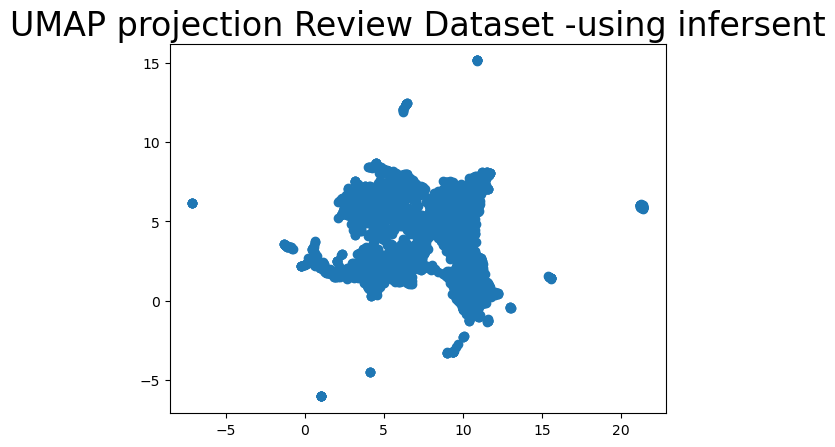

In [26]:
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection Review Dataset -using infersent', fontsize=24);

# DBSCAN Clustering

#### Finding optimal min_sample and eps for DBSCAN

In [27]:
# n_neighbors = 5 as kneighbors function returns distance of point to itself (i.e. first column will be zeros) 
nbrs = NearestNeighbors(n_neighbors=5).fit(umap_embedding)
# Find the k-neighbors of a point
neigh_dist, neigh_ind = nbrs.kneighbors(umap_embedding)
# sort the neighbor distances (lengths to points) in ascending order
# axis = 0 represents sort along first axis i.e. sort along row
sort_neigh_dist = np.sort(neigh_dist, axis=0)

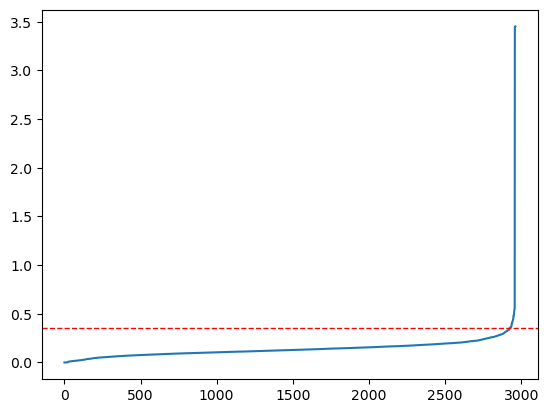

In [28]:
k_dist = sort_neigh_dist[:, 4]
plt.plot(k_dist)
plt.axhline(y=0.35, linewidth=1, linestyle='dashed', color='red')
# plt.ylabel("k-NN distance")
# plt.xlabel("Sorted observations (4th NN)")
plt.show()

In [29]:
dbscan = DBSCAN(eps = 0.35, min_samples = 10).fit(umap_embedding) # fitting the model
labels = dbscan.labels_ # getting the labels

In [30]:
len(labels)

2962

In [31]:
umap_embedding

array([[10.893151 ,  6.4450336],
       [ 9.745526 ,  4.844955 ],
       [ 9.561422 ,  2.1488132],
       ...,
       [11.705781 ,  8.078931 ],
       [ 4.0806956,  7.216563 ],
       [ 5.9312434,  5.7711906]], dtype=float32)

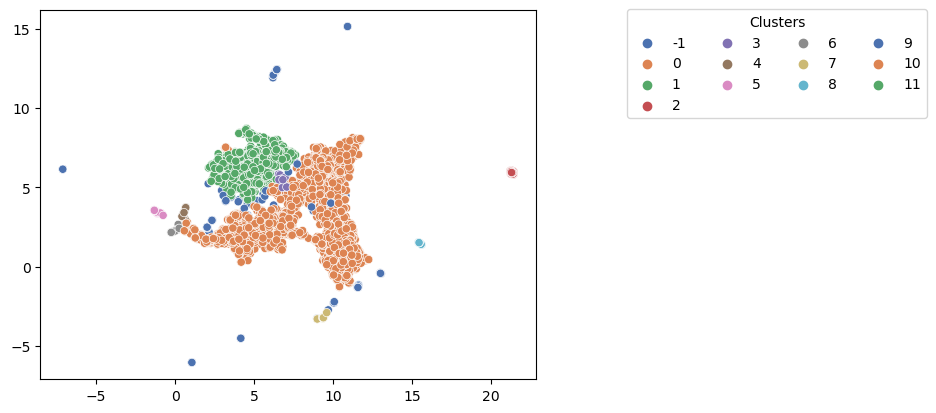

In [32]:
p = sns.scatterplot(data=umap_embedding, x=umap_embedding[:, 0], y=umap_embedding[:,1], hue=labels, legend="full", palette="deep") # Scatter Setting
sns.move_legend(p, "best", bbox_to_anchor=(1.17, 1.02), title='Clusters', ncol=4) # Legend Setting
plt.show() # showing the plot

In [52]:
df_inferSent_dbscan = df_inferSent.copy()
df_inferSent_dbscan['Cluster'] = labels
df_inferSent_dbscan

,data,target,Cluster
0,precompiled version hp2xx dos prefereably 386 486,0,0
1,games shown us wc thanks,1,0
2,well opinion canucks played really strong game...,1,0
3,carl placebo effect hypothesised sensory respo...,2,-1
4,appreciated pierre turgeon formely sabres isle...,1,0
...,...,...,...
2957,places temp files places current directory beg...,0,0
2958,heard news mike keenan formerly blackhawks fly...,1,0
2959,ditto,0,0
2960,35 recovering case chicken pox contracted 5 ye...,2,1


# DBSCAN Accuracy adnd FMI

### Accuracy

In [54]:
accuracy_score(df_inferSent_dbscan['target'].tolist(), df_inferSent_dbscan['Cluster'].tolist())

0.3136394328156651

### FMI

In [55]:
fowlkes_mallows_score(df_inferSent_dbscan['target'].tolist(), df_inferSent_dbscan['Cluster'].tolist())

0.5548766474577851

# KMeans Clustering

In [33]:
silhouette_coefficients = []
number_of_clusters = []


kmeans_kwargs = {
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 2022,}

for k in range(2, 5):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(umap_embedding)
    score = silhouette_score(umap_embedding, kmeans.labels_)
    silhouette_coefficients.append(score)
    number_of_clusters.append(k)
# silhouette_coefficients
df_coefficients = pd.DataFrame(data={"Number of Clusters":number_of_clusters , "Silhouette coefficients":silhouette_coefficients})
df_coefficients[df_coefficients['Number of Clusters'] < 50].sort_values(by=['Silhouette coefficients'],ascending=False).head(20)

,Number of Clusters,Silhouette coefficients
2,4,0.441200
1,3,0.402290
0,2,0.399702


In [34]:
num_clusters = 3

kmeans = KMeans(n_clusters=num_clusters,init="k-means++")
kmeans.fit(umap_embedding)
clusters = kmeans.labels_.tolist()

# clusters

In [56]:
df_inferSent_kmeans = df_inferSent.copy()
df_inferSent_kmeans['Cluster'] = clusters
df_inferSent_kmeans

,data,target,Cluster
0,precompiled version hp2xx dos prefereably 386 486,0,0
1,games shown us wc thanks,1,0
2,well opinion canucks played really strong game...,1,1
3,carl placebo effect hypothesised sensory respo...,2,0
4,appreciated pierre turgeon formely sabres isle...,1,0
...,...,...,...
2957,places temp files places current directory beg...,0,2
2958,heard news mike keenan formerly blackhawks fly...,1,1
2959,ditto,0,0
2960,35 recovering case chicken pox contracted 5 ye...,2,2


In [57]:
df_inferSent_kmeans['target'].value_counts()

1    999
2    990
0    973
Name: target, dtype: int64

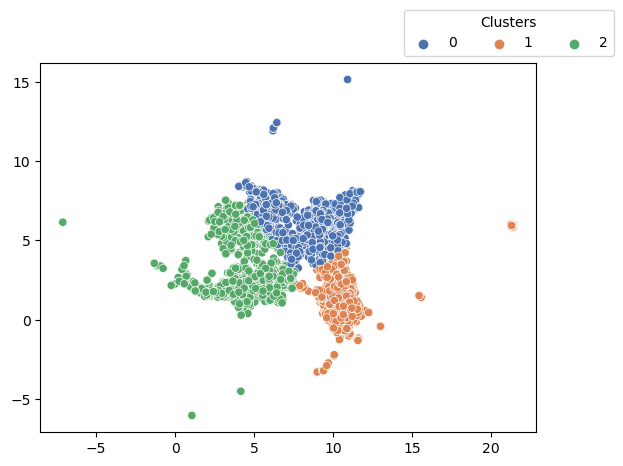

In [37]:
p = sns.scatterplot(data=umap_embedding, x=umap_embedding[:, 0], y=umap_embedding[:,1], hue=clusters, legend="full", palette="deep")
sns.move_legend(p, "lower right", bbox_to_anchor=(1.17, 1.0), title='Clusters', ncol=3)
plt.show()

In [58]:
df_inferSent_kmeans.sort_values(by=['Cluster'],ascending=False).head(40)

,data,target,Cluster
2215,hi someone point towards articles boids flocki...,0,2
1147,press release huntington medical research inst...,2,2
1160,vesa standard requested vesa vesa 2150 north f...,0,2
1159,shop uses package called cadcore good scan sub...,0,2
2081,interested hearing using implementing 3 d inte...,0,2
1157,unable run quicktime 1 5 iivx running system 7...,0,2
1155,bought diamond stealth 24 months ago seems gre...,0,2
2082,hi need know 256 color graphics mode allows mu...,0,2
2083,drag anymore many veterinarians feel lyme dise...,2,2
1151,principle underlying devices well establish pr...,2,2


In [59]:
df_inferSent_kmeans[df_inferSent_kmeans['target'] == 1].head(20)

,data,target,Cluster
1,games shown us wc thanks,1,0
2,well opinion canucks played really strong game...,1,1
4,appreciated pierre turgeon formely sabres isle...,1,0
6,hey american hockey fans hockey fan sympathize...,1,1
8,imho clement although pleasant personality agg...,1,1
9,always scalpers tickets outside arena might pa...,1,1
10,j j yahooooooooooooooooooooo j j game finally ...,1,1
11,hart trophy orginally awarded time people thin...,1,1
13,would n t put name bottom simply appended stan...,1,0
14,bad got 2 wrong cal chi 5 cal pit 6 7 take sc,1,0


In [60]:
df_inferSent_kmeans[df_inferSent_kmeans['target'] == df_inferSent_kmeans['Cluster']]

,data,target,Cluster
0,precompiled version hp2xx dos prefereably 386 486,0,0
2,well opinion canucks played really strong game...,1,1
5,m sure original respondent reiterate cones res...,2,2
6,hey american hockey fans hockey fan sympathize...,1,1
8,imho clement although pleasant personality agg...,1,1
...,...,...,...
2953,s pretty good article march 6 1993 new scienti...,2,2
2954,ll contact offline,0,0
2958,heard news mike keenan formerly blackhawks fly...,1,1
2959,ditto,0,0


# KMeans Accuracy and FMI

### Accuracy

In [61]:
accuracy_score(df_inferSent_kmeans['target'].tolist(), df_inferSent_kmeans['Cluster'].tolist())

0.4540850776502363

### FMI

In [62]:
fowlkes_mallows_score(df_inferSent_kmeans['target'].tolist(), df_inferSent_kmeans['Cluster'].tolist())

0.510696551512827

# Save all clusters as a csv file

In [76]:
df_inferSent_kmeans.sort_values(by=['Cluster'],ascending=False).to_csv('Cluster_Results/Kmeans_{}.csv'.format(num_clusters))
df_inferSent_dbscan.sort_values(by=['Cluster'],ascending=False).to_csv('Cluster_Results/DBSCAN_{}.csv'.format(len(set(labels))))